<a href="https://colab.research.google.com/github/MdNazmul9/KBI/blob/master/ProteinFunctionPredictionAndComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ################Protein Fnction Prediction#####################


In [2]:
#!pip install Keras

In [3]:

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata

%matplotlib inline

import os
import gc

import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from keras.layers import LSTM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
#from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D
from tensorflow.compat.v1.keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [6]:
import logging
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [7]:
data_path = '/content/gdrive/My Drive/Case_Study/pfam/random_split/'
print('Available data', os.listdir(data_path))

Available data ['train', 'dev', 'test', 'model2.h5', 'model1.h5']


In [8]:

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

In [9]:

df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100131 entries, 0 to 13389
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   family_id         1100131 non-null  object
 1   sequence_name     1100131 non-null  object
 2   family_accession  1100131 non-null  object
 3   aligned_sequence  1100131 non-null  object
 4   sequence          1100131 non-null  object
dtypes: object(5)
memory usage: 50.4+ MB


In [11]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [12]:
df_train.head(1)['sequence'].values[0]

'PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAILAAAGCAAPFEEFSSADAFSSTHVFGTCRMGHDPMRNVVDGWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALALRT'

In [13]:
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1100131
Val size:  126171
Test size:  126171


In [14]:
def calc_unique_cls(train, test, val):
  """
  Prints # unique classes in data sets.
  """
  train_unq = np.unique(train['family_accession'].values)
  val_unq = np.unique(val['family_accession'].values)
  test_unq = np.unique(test['family_accession'].values)

  print('Number of unique classes in Train: ', len(train_unq))
  print('Number of unique classes in Val: ', len(val_unq))
  print('Number of unique classes in Test: ', len(test_unq))

In [15]:
calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


In [16]:
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

In [17]:
def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

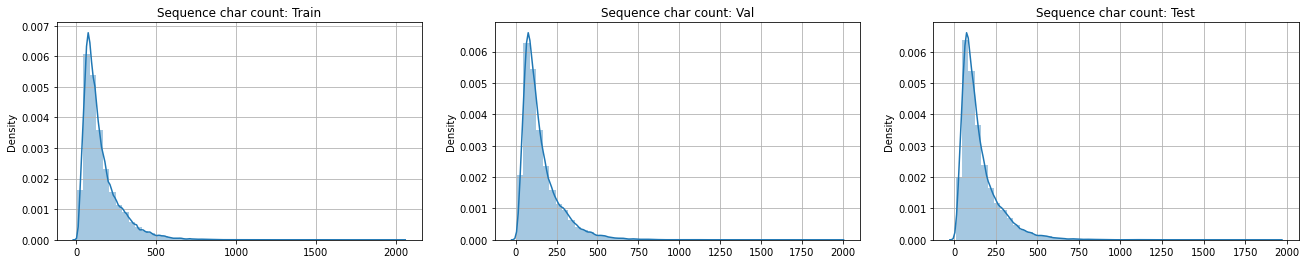

In [18]:
plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [19]:
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [20]:
train_code_freq = get_code_freq(df_train['sequence'], 'Train')
train_code_freq

Codes: Train
Total unique codes: 25


,Code,Freq
0,L,17271999
1,A,14561575
2,V,12060260
3,G,11991696
4,E,10993951
5,S,10727973
6,I,10361299
7,R,9522760
8,D,9486638
9,K,9240898


In [21]:
val_code_freq = get_code_freq(df_val['sequence'], 'Val')
val_code_freq

Codes: Val
Total unique codes: 22


,Code,Freq
0,L,1967025
1,A,1667703
2,V,1382128
3,G,1376124
4,E,1249356
5,S,1210750
6,I,1185722
7,R,1085950
8,D,1080572
9,K,1047638


In [22]:
test_code_freq = get_code_freq(df_test['sequence'], 'Test')
test_code_freq

Codes: Test
Total unique codes: 24


,Code,Freq
0,L,1967046
1,A,1668137
2,V,1380962
3,G,1375349
4,E,1251000
5,S,1210559
6,I,1184239
7,R,1085786
8,D,1078379
9,K,1045957


In [23]:
def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

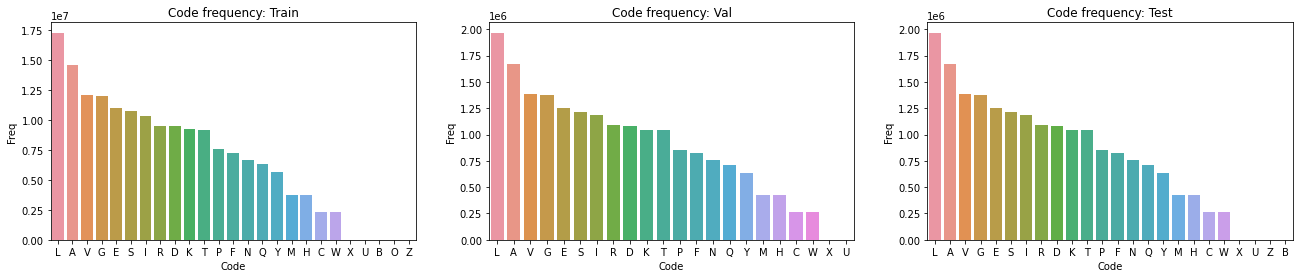

In [24]:
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')
plt.savefig('train_code_freq.png')
plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')
plt.savefig('val_code_freq.png')
plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')
plt.savefig('test_code_freq.png')
plt.subplots_adjust(right=3.0)
plt.show()
plt.savefig('fig.png')

In [25]:
df_train.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    3688
LRR_1              1949
Acetyltransf_7     1777
His_kinase         1565
Bac_transf         1554
Lum_binding        1518
DNA_binding_1      1359
Chromate_transp    1283
Lipase_GDSL_2      1264
DnaJ_CXXCXGXG      1228
SRP54_N            1197
WD40               1195
OTCace_N           1175
PEP-utilizers      1161
Glycos_trans_3N    1154
THF_DHG_CYH        1124
Prenyltransf       1117
DHH                1076
HTH_1              1074
Maf                1070
dtype: int64

In [26]:
df_val.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
Prenyltransf       138
THF_DHG_CYH        138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [27]:
df_test.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
Prenyltransf       138
THF_DHG_CYH        138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [28]:

classes = df_train['family_accession'].value_counts()[:1000].index.tolist()
len(classes)

1000

In [29]:
# Filtering data based on considered 1000 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 1000 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

Data size after considering 1000 classes for each data split:
Train size : 444906
Val size : 54378
Test size : 54378


In [30]:
calc_unique_cls(train_sm, test_sm, val_sm)

Number of unique classes in Train:  1000
Number of unique classes in Val:  1000
Number of unique classes in Test:  1000


In [31]:

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [32]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [33]:
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm)

In [34]:

max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((444906, 100), (54378, 100), (54378, 100))

In [35]:

train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)

train_ohe.shape, test_ohe.shape, test_ohe.shape

((444906, 100, 21), (54378, 100, 21), (54378, 100, 21))

In [36]:
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((444906,), (54378,), (54378,))

In [37]:
print('Total classes: ', len(le.classes_))

Total classes:  1000


In [38]:
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((444906, 1000), (54378, 1000), (54378, 1000))

In [39]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [40]:

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

# Model 1: RNNEDT

In [55]:
"""import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()"""
from keras.layers import LSTM

x_input = Input(shape=(100,))
emb = Embedding(21, 128, input_length=max_length)(x_input)
bi_rnn = Bidirectional(CuDNNLSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(1000, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#metrics=["acc"]
model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          2688      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               99328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              129000    
Total params: 231,016
Trainable params: 231,016
Non-trainable params: 0
_________________________________________________________________


In [56]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [57]:
##from keras.layers import LSTM

history1 = model1.fit(
    train_pad, y_train,
    epochs=50, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es]
    )

Epoch 1/50
1738/1738 [==============================] - 43s 24ms/step - loss: 6.9816 - acc: 0.0433 - val_loss: 3.6589 - val_acc: 0.3237
Epoch 2/50
1738/1738 [==============================] - 41s 24ms/step - loss: 3.2858 - acc: 0.3854 - val_loss: 2.0586 - val_acc: 0.6637
Epoch 3/50
1738/1738 [==============================] - 42s 24ms/step - loss: 2.0802 - acc: 0.6290 - val_loss: 1.3847 - val_acc: 0.7893
Epoch 4/50
1738/1738 [==============================] - 42s 24ms/step - loss: 1.5510 - acc: 0.7314 - val_loss: 1.0622 - val_acc: 0.8451
Epoch 5/50
1738/1738 [==============================] - 42s 24ms/step - loss: 1.2651 - acc: 0.7846 - val_loss: 0.8785 - val_acc: 0.8785
Epoch 6/50
1738/1738 [==============================] - 41s 24ms/step - loss: 1.0980 - acc: 0.8149 - val_loss: 0.7766 - val_acc: 0.8954
Epoch 7/50
1738/1738 [==============================] - 42s 24ms/step - loss: 0.9840 - acc: 0.8353 - val_loss: 0.7264 - val_acc: 0.9011
Epoch 8/50
1738/1738 [==========================

In [59]:
import tensorflow as tf
print(tf.test.is_gpu_available())

True


In [60]:
model1.save_weights('/content/gdrive/My Drive/Case_Study/pfam/random_split/model1.h5')
#model1.save_weights('model1.h5')

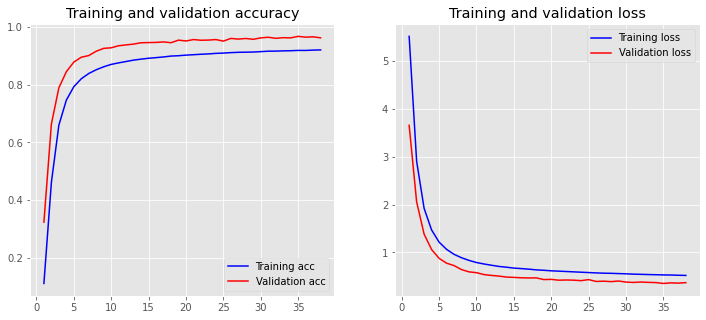

In [61]:
plot_history(history1)


In [62]:
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [test_pad, y_test],
    256)

1738/1738 [==============================] - 18s 11ms/step - loss: 0.3484 - acc: 0.9689
Train loss:  0.34835612773895264
Train accuracy:  0.9648653349876404
----------------------------------------------------------------------
213/213 [==============================] - 2s 11ms/step - loss: 0.3698 - acc: 0.9626
Val loss:  0.36980682611465454
Val accuracy:  0.957558388710022
----------------------------------------------------------------------
213/213 [==============================] - 2s 11ms/step - loss: 0.3732 - acc: 0.9619
Test loss:  0.3732147216796875
Test accuracy:  0.9581595838546753


In [63]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [69]:
# model

x_input = Input(shape=(100, 21))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1000, activation='softmax', kernel_regularizer=l2(0.0001))(x)

model2 = Model(inputs=x_input, outputs=x_output)
#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 21)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 100, 128)     2816        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 100, 128)     512         conv1d_10[0][0]                  
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 100, 128)     0           batch_normalization_8[0][0]      
____________________________________________________________________________________________

In [70]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [71]:
history2 = model2.fit(
    train_ohe, y_train,
    epochs=10, batch_size=256,
    validation_data=(val_ohe, y_val),
    callbacks=[es]
    )

Epoch 1/10
1738/1738 [==============================] - 36s 20ms/step - loss: 1.6739 - acc: 0.8274 - val_loss: 0.4631 - val_acc: 0.9836
Epoch 2/10
1738/1738 [==============================] - 35s 20ms/step - loss: 0.4259 - acc: 0.9822 - val_loss: 0.4469 - val_acc: 0.9853
Epoch 3/10
1738/1738 [==============================] - 34s 20ms/step - loss: 0.4146 - acc: 0.9842 - val_loss: 0.4445 - val_acc: 0.9850
Epoch 4/10
1738/1738 [==============================] - 35s 20ms/step - loss: 0.4031 - acc: 0.9856 - val_loss: 0.4396 - val_acc: 0.9851
Epoch 5/10
1738/1738 [==============================] - 35s 20ms/step - loss: 0.4003 - acc: 0.9856 - val_loss: 0.4251 - val_acc: 0.9862
Epoch 6/10
1738/1738 [==============================] - 35s 20ms/step - loss: 0.3897 - acc: 0.9865 - val_loss: 0.4216 - val_acc: 0.9862
Epoch 7/10
1738/1738 [==============================] - 35s 20ms/step - loss: 0.3844 - acc: 0.9864 - val_loss: 0.4104 - val_acc: 0.9867
Epoch 8/10
1738/1738 [==========================

In [72]:
model2.save_weights('/content/gdrive/My Drive/Case_Study/pfam/random_split/model2.h5')

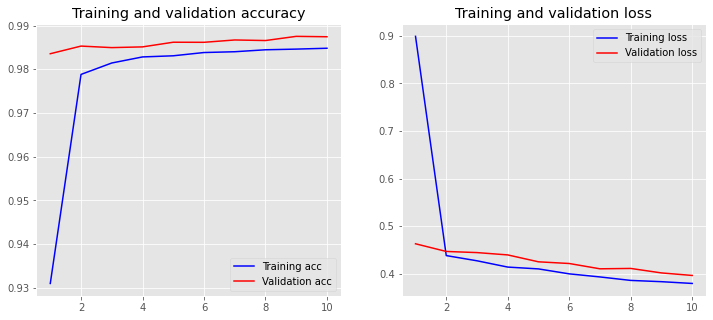

In [73]:
plot_history(history2)

In [74]:
display_model_score(
    model2,
    [train_ohe, y_train],
    [val_ohe, y_val],
    [test_ohe, y_test],
    256)

1738/1738 [==============================] - 18s 11ms/step - loss: 0.3484 - acc: 0.9689
Train loss:  0.34835612773895264
Train accuracy:  0.9688653349876404
----------------------------------------------------------------------
213/213 [==============================] - 2s 11ms/step - loss: 0.3698 - acc: 0.9626
Val loss:  0.36980682611465454
Val accuracy:  0.962558388710022
----------------------------------------------------------------------
213/213 [==============================] - 2s 11ms/step - loss: 0.3732 - acc: 0.9619
Test loss:  0.3732147216796875
Test accuracy:  0.9618595838546753


In [76]:
x = PrettyTable()
x.field_names = ['Sr.no', 'Model', 'Train Acc', 'Val Acc','Test Acc']

x.add_row(['1.', 'RNNEDT', '0.968', '0.962', '0.961'])
x.add_row(['3.', 'Bidirectional LSTM', '0.964', '0.957', '0.958'])

print(x)

+-------+--------------------+-----------+---------+----------+
| Sr.no |       Model        | Train Acc | Val Acc | Test Acc |
+-------+--------------------+-----------+---------+----------+
|   1.  |       RNNEDT       |   0.968   |  0.962  |  0.961   |
|   3.  | Bidirectional LSTM |   0.964   |  0.957  |  0.958   |
+-------+--------------------+-----------+---------+----------+
